In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import label, binary_erosion 

In [2]:
image = cv2.imread("/mnt/e/Term 4/HW/DIP-HW8/data/images/q4/cells.png", cv2.IMREAD_GRAYSCALE)

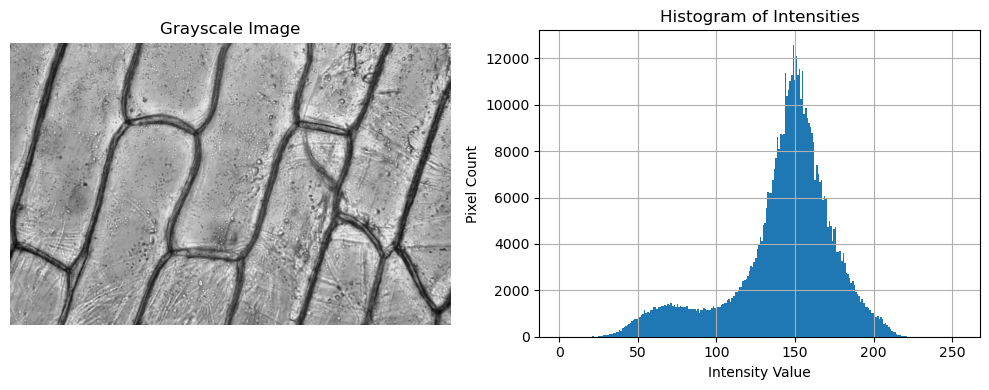

In [7]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Grayscale Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Histogram of Intensities")
plt.hist(image.ravel(), bins=256, range=(0,255))
plt.xlabel('Intensity Value')
plt.ylabel('Pixel Count')
plt.grid(True)
plt.tight_layout()
plt.show()

(-0.5, 949.5, 607.5, -0.5)

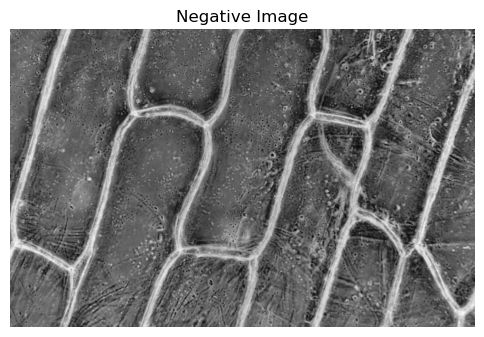

In [11]:
negative_image = 255 - image

plt.figure(figsize=(6, 6))
plt.title("Negative Image")
plt.imshow(negative_image, cmap='gray')
plt.axis('off')

In [12]:
image.shape

(608, 950)

In [39]:
h, w = image.shape

seed = (210, 130)
queue = [seed]

neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1),
            (-1, -1), (-1, 1), (1, -1), (1, 1)]

threshold = 5

segmented = np.zeros_like(image, dtype=np.uint8)
visited = np.zeros_like(image, dtype=bool)

region_mean = int(image[seed])
visited[seed] = True
segmented[seed] = 255

while queue:
    x, y = queue.pop(0)

    for dx, dy in neighbors:
        nx, ny = x + dx, y + dy

        if nx >=0 and ny >= 0 and nx < h and ny < w and not visited[nx, ny]:
            if abs(int(image[nx, ny] - region_mean) <= threshold):
                segmented[nx, ny] = 255
                visited[nx, ny] = True
                queue.append((nx, ny))


(-0.5, 949.5, 607.5, -0.5)

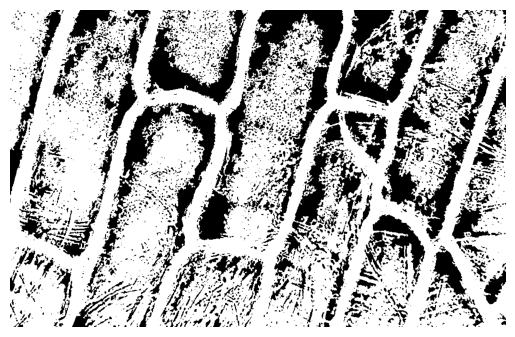

In [42]:
plt.imshow(segmented, cmap='grey')
plt.axis('off')

In [69]:
def region_growing(image, seeds, threshold):
    """
    Region Growing Segmentation
    ----------------------------
    image:     grayscale input image
    seeds:     list of (row, col) seed points
    threshold: intensity similarity threshold
    """
    
    # Get image dimensions
    h, w = image.shape
    
    # Output image: each region gets a unique label (1, 2, 3, ...)
    segmented = np.zeros((h, w), dtype=np.uint8)
    
    # Keep track of visited pixels (True = already processed)
    visited = np.zeros((h, w), dtype=bool)
    
    # Define 8-connected neighbors
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1),
                 (-1, -1), (-1, 1), (1, -1), (1, 1)]
    
    # Process each seed separately
    for region_id, seed in enumerate(seeds, start=1):
        queue = [seed]                       # BFS queue starts with seed
        region_mean = int(image[seed])       # initial region intensity
        
        segmented[seed] = region_id          # mark seed in segmented image
        visited[seed] = True                 # mark seed as visited
        
        # Breadth-First Search (BFS)
        while queue:
            x, y = queue.pop(0)              # get first pixel from queue
            
            # Check all 8 neighbors
            for dx, dy in neighbors:
                nx, ny = x + dx, y + dy
                
                # Check if within bounds and not visited
                if 0 <= nx < h and 0 <= ny < w and not visited[nx, ny]:
                    # Similarity check: intensity difference ≤ threshold
                    if abs(int(image[nx, ny]) - region_mean) <= threshold:
                        segmented[nx, ny] = region_id   # assign region label
                        visited[nx, ny] = True          # mark as visited
                        queue.append((nx, ny))          # add to queue
    
    return segmented


In [ ]:
segmented_image = region_growing(image=image, 
                                seeds=[(210, 130), (280, 310), (40, 350), (300, 780), (150, 514)],  # I use only 5 seeds.
                                threshold=13)

(-0.5, 949.5, 607.5, -0.5)

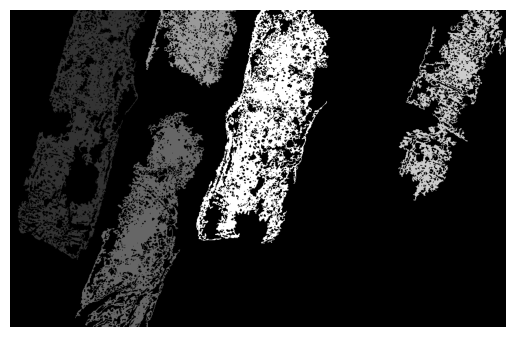

In [71]:
plt.imshow(segmented_image, cmap='grey')
plt.axis('off')

___

In [3]:
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

(-0.5, 949.5, 607.5, -0.5)

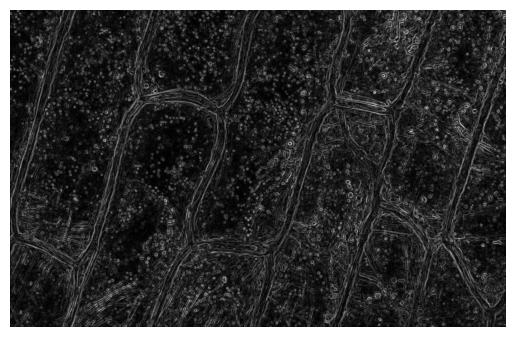

In [7]:
sobel_x = cv2.Sobel(src=image, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3)
sobel_y = cv2.Sobel(src=image, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3)

gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
gradient_mag_norm = cv2.normalize(src=gradient_magnitude, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

gradient_mag_norm = np.uint8(gradient_mag_norm)

plt.imshow(gradient_mag_norm, cmap='grey')
plt.axis('off')


Threshold using otsu is: 119.0


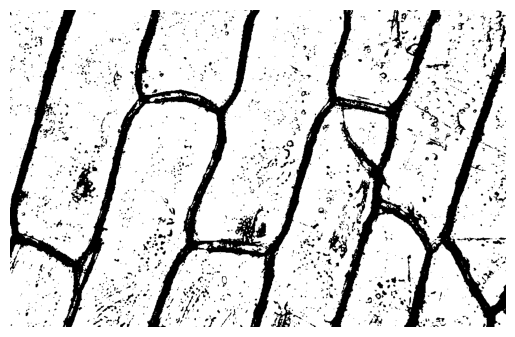

In [43]:
ret, binary = cv2.threshold(src=image, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(binary, cmap='grey')
plt.axis('off')

print(f'Threshold using otsu is: {ret}')

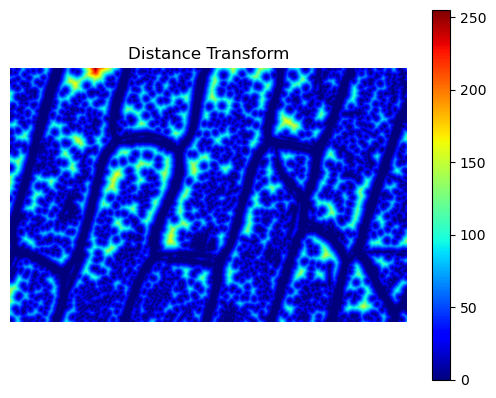

In [44]:
distance = cv2.distanceTransform(src=binary, distanceType=cv2.DIST_L2, maskSize=3)

dist_norm = cv2.normalize(distance, None, 0, 255, cv2.NORM_MINMAX)

plt.imshow(dist_norm, cmap='jet') 
plt.colorbar()  
plt.title("Distance Transform")
plt.axis('off')
plt.show()

(-0.5, 949.5, 607.5, -0.5)

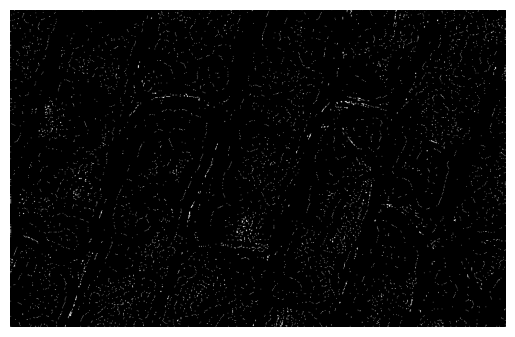

In [45]:
coordinates = peak_local_max(image=distance, footprint=np.ones((3, 3)), labels=binary)

local_maxi = np.zeros_like(distance, dtype=bool)
local_maxi[coordinates.T[0], coordinates.T[1]] = True

plt.imshow(local_maxi, cmap='grey')
plt.axis('off')

In [46]:
# Label the connected components (local maxima) to create unique markers for watershed
markers, _ = ndi.label(local_maxi)

In [47]:
# Apply watershed algorithm on the gradient image
labels = watershed(gradient_magnitude, markers)

(-0.5, 949.5, 607.5, -0.5)

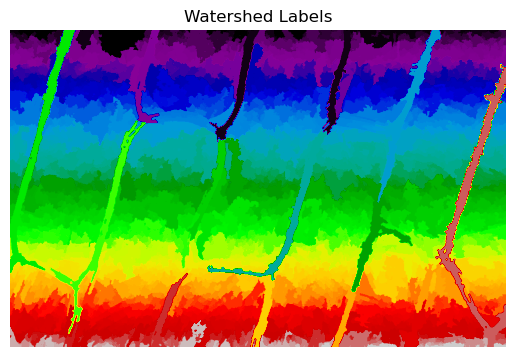

In [50]:
plt.title('Watershed Labels')
plt.imshow(labels, cmap='nipy_spectral')
plt.axis('off')